In [1]:
import pandas as pd
import data_preprocess as dp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# set decimal places to 4
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
data = pd.read_csv('./data/D2.csv')

In [4]:
df = dp.data_prep(data, verbose=True)

Running drop_columns_with_missing_values...
Running recode_medical_specialty...
Running recode_admission_type...
Running recode_discharge_disposition...
Running recode_admission_source...
Running recode_binary_values...
Running recode_drug_columns...
Running recode_age_column...
Running drop_deceased_patients...
Data preparation complete.


In [5]:
rs = 1

In [6]:
# Step 1: Separating the features and target variable
X = df.drop('readmitted', axis=1)  # Features
y = df['readmitted']  # Target variable  


In [7]:
# Identifying categorical columns that need encoding
categorical_columns = ['race', 'medical_specialty', 'admission_type', 'discharge_disposition', 'admission_source']
numerical_columns = ['gender', 'age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                     'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
                     'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
                     'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'insulin', 'change', 'diabetesMed']

In [8]:
label_encoder = LabelEncoder()
X['age'] = label_encoder.fit_transform(X['age'])

In [9]:
X = pd.get_dummies(X, columns=categorical_columns, dtype=int)

In [10]:
scaler = MinMaxScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rs)

In [12]:
# Import the model
from sklearn.linear_model import LogisticRegression

# Instantiate the default model
base_model = LogisticRegression(random_state=rs, max_iter=2000)
base_model.fit(X_train, y_train)

LogisticRegression(max_iter=2000, random_state=1)

In [13]:
# perform cross validation with gridsearchCV
from sklearn.model_selection import GridSearchCV

In [14]:
# defining the hyperparameters
params = {
    'C': [pow(10, x) for x in range(-4, 6)],
}

In [15]:
# Instantiating the gridsearch
grid_model = GridSearchCV(param_grid=params, estimator=base_model, return_train_score=True, cv=10, n_jobs=-1)
grid_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=2000, random_state=1),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000, 100000]},
             return_train_score=True)

In [16]:
y_pred_grid = grid_model.predict(X_test)

In [17]:
best_params = grid_model.best_params_

In [18]:
print(f"Best accuracy score: {accuracy_score(y_test, y_pred_grid):.3f}")
print(f"Best training accuracy: {accuracy_score(y_train, grid_model.best_estimator_.predict(X_train)):.3f}")
print(f"Best test accuracy: {accuracy_score(y_test, y_pred_grid):.3f}")

Best accuracy score: 0.630
Best training accuracy: 0.631
Best test accuracy: 0.630


In [19]:
grid_search = LogisticRegression(C=0.1, random_state=rs, max_iter=2000)
grid_search.fit(X_train, y_train)

# Get feature importances (coefficients) from the logistic regression model
importance = grid_search.coef_[0]

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

top_5_features = feature_importance_df.reindex(
    feature_importance_df['Importance'].abs().sort_values(ascending=False).index).head(5)
top_5_features

,Feature,Importance
8,number_inpatient,4.5676
6,number_outpatient,1.2977
7,number_emergency,0.8453
5,num_medications,0.7607
9,number_diagnoses,0.7252


In [20]:
# Training and test accuracy
from sklearn.metrics import accuracy_score

# Predict on the training and test sets
y_train_pred = grid_model.best_estimator_.predict(X_train)
y_test_pred = grid_model.best_estimator_.predict(X_test)

# Calculate training and test accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracy scores
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.6305
Test Accuracy: 0.6296


In [21]:
from sklearn.feature_selection import RFECV

In [22]:
rfecv = RFECV(estimator=grid_search, cv=10, n_jobs=-1, scoring='accuracy')
rfecv.fit(X_train, y_train)

RFECV(cv=10, estimator=LogisticRegression(C=0.1, max_iter=2000, random_state=1),
      n_jobs=-1, scoring='accuracy')

In [23]:
print(f"Original feature set: {X_train.shape[1]}")
print(f"Optimal number of features : {rfecv.n_features_}")

Original feature set: 42
Optimal number of features : 25


In [24]:
X_train_rfecv = rfecv.transform(X_train)
X_test_rfecv = rfecv.transform(X_test)

In [25]:
grid_model_rfecv = GridSearchCV(estimator=grid_search, param_grid=params,  cv=10, scoring='accuracy', return_train_score=True)
grid_model_rfecv.fit(X_train_rfecv, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(C=0.1, max_iter=2000, random_state=1),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000, 100000]},
             return_train_score=True, scoring='accuracy')

In [26]:
y_pred_rfecv = grid_model_rfecv.predict(X_test_rfecv)
print(f"Best accuracy score: {accuracy_score(y_test, y_pred_rfecv):.3f}")
print(f"Best training accuracy: {accuracy_score(y_train, grid_model_rfecv.best_estimator_.predict(X_train_rfecv)):.3f}")
print(f"Best test accuracy: {accuracy_score(y_test, y_pred_rfecv):.3f}")

Best accuracy score: 0.629
Best training accuracy: 0.631
Best test accuracy: 0.629


In [27]:
best_params_rfecv = grid_model_rfecv.best_params_
best_params_rfecv

{'C': 1000}

In [28]:
# Get the boolean mask of selected features from the RFECV model
selected_features_mask = rfecv.support_

# Get the names of the selected features
selected_features = X.columns[selected_features_mask]

# Get the coefficients of the final tuned logistic regression model
coefficients = grid_model_rfecv.best_estimator_.coef_[0]

# Create a dataframe of the selected features and their corresponding coefficients
important_features_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': coefficients
})

# Sort the features by absolute importance and get the top 5
top_5_features_rfecv = important_features_df.reindex(important_features_df['Importance'].abs().sort_values(ascending=False).index).head(5)
top_5_features_rfecv


,Feature,Importance
5,number_emergency,15.1817
6,number_inpatient,7.9349
10,chlorpropamide,5.1940
4,number_outpatient,3.4305
3,num_medications,0.7609


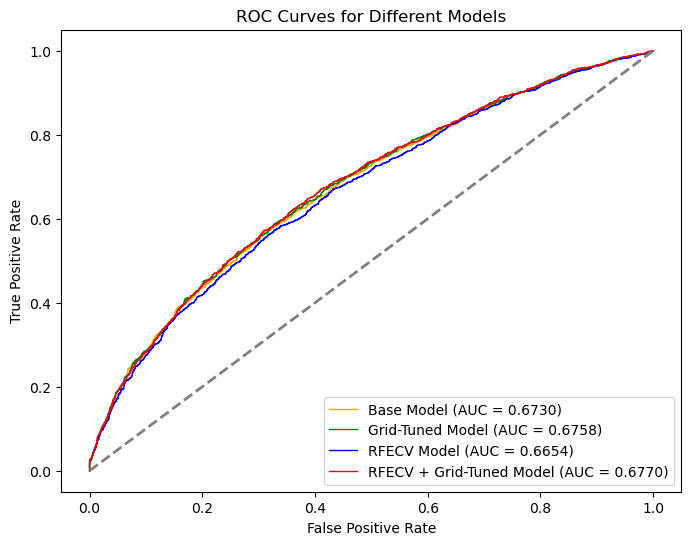

In [29]:
# Now, compute the ROC curves for all four models
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Base model
y_score_base = base_model.decision_function(X_test)
fpr_base, tpr_base, _ = roc_curve(y_test, y_score_base)
roc_auc_base = auc(fpr_base, tpr_base)

# Grid-tuned model
y_score_grid = grid_model.decision_function(X_test)
fpr_grid, tpr_grid, _ = roc_curve(y_test, y_score_grid)
roc_auc_grid = auc(fpr_grid, tpr_grid)

# RFECV model
y_score_rfecv = rfecv.estimator_.decision_function(X_test_rfecv)
fpr_rfecv, tpr_rfecv, _ = roc_curve(y_test, y_score_rfecv)
roc_auc_rfecv = auc(fpr_rfecv, tpr_rfecv)

# RFECV + Grid-tuned model
y_score_grid_rfecv = grid_model_rfecv.decision_function(X_test_rfecv)
fpr_grid_rfecv, tpr_grid_rfecv, _ = roc_curve(y_test, y_score_grid_rfecv)
roc_auc_grid_rfecv = auc(fpr_grid_rfecv, tpr_grid_rfecv)

# Plotting the ROC curves for all models
plt.figure(figsize=(8, 6))

plt.plot(fpr_base, tpr_base, color='orange', lw=1, label=f'Base Model (AUC = {roc_auc_base:.4f})')
plt.plot(fpr_grid, tpr_grid, color='green', lw=1, label=f'Grid-Tuned Model (AUC = {roc_auc_grid:.4f})')
plt.plot(fpr_rfecv, tpr_rfecv, color='blue', lw=1, label=f'RFECV Model (AUC = {roc_auc_rfecv:.4f})')
plt.plot(fpr_grid_rfecv, tpr_grid_rfecv, color='red', lw=1, label=f'RFECV + Grid-Tuned Model (AUC = {roc_auc_grid_rfecv:.4f})')

# Plot diagonal line for reference (random guessing)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc="lower right")

# Show plot
plt.show()

